# CSC 215 - Final Project

# Gender Classification with Deep Learning

## Khoi Hoang

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import time
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from IPython.display import Markdown, display
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Helper function
# Print markdown style
def printmd(string):
    display(Markdown(string))
    
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=90)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Manually load images

In [3]:
IMAGES_DIRECTORY = "C:/Users/hgdan/Downloads/lfw-deepfunneled/"

In [4]:
people = os.listdir(path=IMAGES_DIRECTORY)
print("There are {} people in the full lfw dataset.".format(len(people)))

There are 5749 people in the full lfw dataset.


In [5]:
image_array = []
for directory in os.listdir(IMAGES_DIRECTORY):
    image_dir = IMAGES_DIRECTORY + directory #go to sub directories
    for image in os.listdir(image_dir):
        image = plt.imread(os.path.join(image_dir, image))
        #image = cv2.resize(image, (100, 100))
        image_array.append(image)

In [6]:
image_array = np.array(image_array)
image_array.shape

(13233, 250, 250, 3)

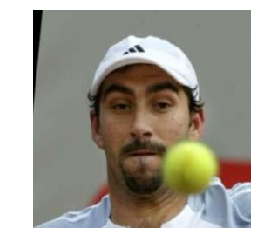

In [7]:
sample = 197

each = image_array[sample]

plt.figure()
plt.axis('off')
plt.imshow(each)
plt.show()

#### Making the gender labels for the output

In [8]:
df_male = pd.read_csv("gender_labels/male_names.txt")
df_female = pd.read_csv("gender_labels/female_names.txt")

In [9]:
df_female.head()

,Pics
0,Claudia_Coslovich_0001.jpg
1,Allison_Searing_0001
2,Elizabeth_Hill_0001.jpg
3,Erika_Reyes_0001.jpg
4,Tatiana_Shchegoleva_0001.jpg


In [10]:
# Helper function to convert the df into list of names for males or females
def gender_to_list(df):
    temp = df.values
    temp = temp.reshape(temp.shape[0],)
    
    res = []
    for each in temp:
        each = each.rsplit('_', 1)[0]
        res.append(each)
    
    return res

In [11]:
male = gender_to_list(df_male)
female = gender_to_list(df_female)

In [12]:
female[0:5]

['Claudia_Coslovich',
 'Allison_Searing',
 'Elizabeth_Hill',
 'Erika_Reyes',
 'Tatiana_Shchegoleva']

In [13]:
gender_target = []
for each in os.listdir(IMAGES_DIRECTORY): #iterate through the subdir
    if each in male:
        for i in range(len(os.listdir(IMAGES_DIRECTORY + each))):
            gender_target.append('male')
    elif each in female:
        for i in range(len(os.listdir(IMAGES_DIRECTORY + each))):
            gender_target.append('female')
    else:
        print(each)

In [14]:
gender_target = np.array(gender_target)
gender_target.shape

(13233,)

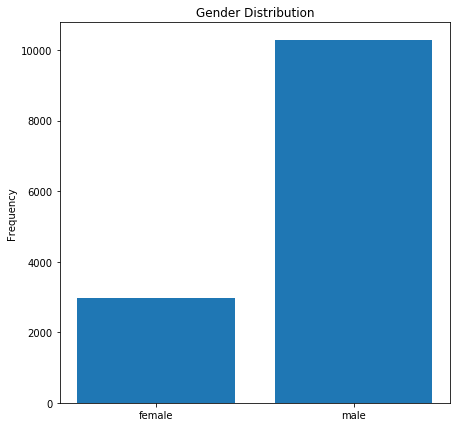

In [15]:
label, count_gender = np.unique(gender_target, return_counts=True)
y_pos = np.arange(2)
plt.figure(figsize=(7,7))
plt.bar(y_pos, count_gender, align='center')
plt.title("Gender Distribution")
plt.xticks(y_pos, label)
plt.ylabel("Frequency")
plt.show()

As we can see in the graph, the data is highly imbalanced. There are two ways to deal with imbalanced data:
  * Undersampling, we can reduce the number of male images to roughly 3k to balance the number of female images. However, this is not ideal because bigger data helps CNN train better
  * Oversampling, which is the technique I will apply in this project, is to increase the samples of imbalanced data. I will apply image augmentation on the female images to balance the male images

# Data balancing and Image Augmentation

In [16]:
female_images = []
male_images = []
for i in range(len(gender_target)):
    if gender_target[i] == 'female':
        female_images.append(image_array[i])
    else:
        male_images.append(image_array[i])
        
female_images = np.array(female_images)
male_images = np.array(male_images)
print(female_images.shape)
print(male_images.shape)

(2962, 250, 250, 3)
(10271, 250, 250, 3)


In [92]:
from keras.preprocessing.image import ImageDataGenerator

img_gen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

i=0
for batch in img_gen.flow(female_images, batch_size=1, 
                          save_to_dir="augmented",
                          save_format='jpg'):
    i+=1
    if i==7309:
        break
    

In [19]:
# read new augmented images
augmented_images = []
for image in os.listdir('augmented'):
    image = plt.imread(os.path.join('augmented/', image))
    augmented_images.append(image)

In [20]:
augmented_images = np.array(augmented_images)

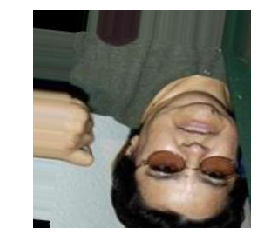

In [21]:
plt.figure()
plt.axis('off')
plt.imshow(augmented_images[0])
plt.show()

In [22]:
female_images = np.concatenate((female_images, augmented_images), axis=0)
female_images.shape

(10271, 250, 250, 3)

In [23]:
print("Number of male images: {}".format(male_images.shape[0]))
print("Number of female images: {}".format(female_images.shape[0]))

Number of male images: 10271
Number of female images: 10271


In [24]:
input_images = np.concatenate((male_images, female_images), axis=0)
output_label = np.zeros(input_images.shape[0])

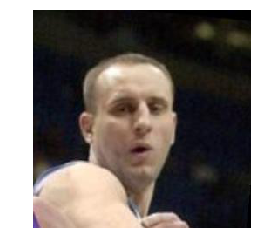

In [25]:
plt.figure()
plt.axis('off')
plt.imshow(input_images[10270])
plt.show()

In [26]:
# the first half is 0 (males), second half is 1 (females)
output_label[10271:] = 1

In [27]:
# Resize the images
start = time.time()
input_images_resized = []
for each in input_images:
    each = cv2.resize(each, (100, 100))
    input_images_resized.append(each)

input_images_resized = np.array(input_images_resized)
print(input_images_resized.shape)
end = time.time()
print("Total time is {:0.2f}s".format(end-start))

(20542, 100, 100, 3)
Total time is 6.45s


# Deep CNN model

In [28]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers, regularizers
from sklearn import metrics
from keras.optimizers import Adam
from keras.models import load_model

In [29]:
x_train, x_test, y_train, y_test = train_test_split(input_images_resized, output_label, test_size=0.2, random_state=43)
#x_train, x_test, y_train, y_test = train_test_split(input_images, output_label, test_size=0.2, random_state=43)

In [30]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(16433, 100, 100, 3)
(16433,)
(4109, 100, 100, 3)
(4109,)


In [31]:
np.unique(y_test, return_counts=True)

(array([0., 1.]), array([2043, 2066], dtype=int64))

In [32]:
# Normalize the data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.0
x_test /= 255.0

In [33]:
y_train

array([1., 0., 1., ..., 1., 1., 1.])

In [34]:
# One hot encode the gender
y_train = keras.utils.to_categorical(y_train, 2)
y_test = keras.utils.to_categorical(y_test, 2)

In [35]:
y_test[0:5]

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [53]:
start = time.time()
checkpointer = ModelCheckpoint(filepath="save/deepcnn.hdf5", verbose=0, save_best_only=True) # save best model
#input_shape = (250, 250, 3)
input_shape = (100, 100, 3)
learning_rate = 0.001

#Build network
model = Sequential()

model.add(Conv2D(96, kernel_size=(3, 3), strides=(1, 1), padding='valid',
                 activation='relu',
                 input_shape=input_shape)) 
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
model.add(Dropout(0.25)) 

model.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='valid',activation='relu')) 
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
model.add(Dropout(0.25)) 

model.add(Conv2D(256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
model.add(Dropout(0.25)) 

model.add(Conv2D(512, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
model.add(Dropout(0.25)) 

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.35))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.35))
model.add(Dense(y_train.shape[1], activation='softmax'))

model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=learning_rate), metrics=['accuracy'])

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

model.fit(x_train,y_train, validation_split=0.2, callbacks=[monitor,checkpointer],verbose=1,epochs=50, batch_size=64, shuffle=True)    # Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.
    
print('Training finished...Loading the best model')  
end = time.time()
cnn_time = end-start
print("Total training time is {:0.2f} minute".format(cnn_time/60.0))

Train on 13146 samples, validate on 3287 samples
Epoch 1/50
13146/13146 [==============================] - 20s 2ms/step - loss: 0.6719 - acc: 0.5581 - val_loss: 0.5134 - val_acc: 0.7627
Epoch 2/50
13146/13146 [==============================] - 17s 1ms/step - loss: 0.3992 - acc: 0.8101 - val_loss: 0.3225 - val_acc: 0.8506
Epoch 3/50
13146/13146 [==============================] - 18s 1ms/step - loss: 0.3185 - acc: 0.8565 - val_loss: 0.2821 - val_acc: 0.8768
Epoch 4/50
13146/13146 [==============================] - 18s 1ms/step - loss: 0.2678 - acc: 0.8830 - val_loss: 0.2386 - val_acc: 0.9005
Epoch 5/50
13146/13146 [==============================] - 18s 1ms/step - loss: 0.2244 - acc: 0.9016 - val_loss: 0.1985 - val_acc: 0.9212
Epoch 6/50
13146/13146 [==============================] - 17s 1ms/step - loss: 0.1786 - acc: 0.9251 - val_loss: 0.1718 - val_acc: 0.9285
Epoch 7/50
13146/13146 [==============================] - 18s 1ms/step - loss: 0.1530 - acc: 0.9376 - val_loss: 0.1178 - val_acc:

In [36]:
model = load_model('save/deepcnn.hdf5') # load weights from best model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_105 (Conv2D)          (None, 98, 98, 96)        2688      
_________________________________________________________________
max_pooling2d_102 (MaxPoolin (None, 49, 49, 96)        0         
_________________________________________________________________
dropout_113 (Dropout)        (None, 49, 49, 96)        0         
_________________________________________________________________
conv2d_106 (Conv2D)          (None, 47, 47, 128)       110720    
_________________________________________________________________
max_pooling2d_103 (MaxPoolin (None, 23, 23, 128)       0         
_________________________________________________________________
dropout_114 (Dropout)        (None, 23, 23, 128)       0         
_________________________________________________________________
conv2d_107 (Conv2D)          (None, 23, 23, 256)       295168    
__________

-----------------**Convolutional Neural Network Report**---------------

F1 score: 0.9649524860081315
Accuracy score: 0.9649549768800195
Confusion matrix: 
 [[1995   48]
 [  96 1970]]
Plotting confusion matrix


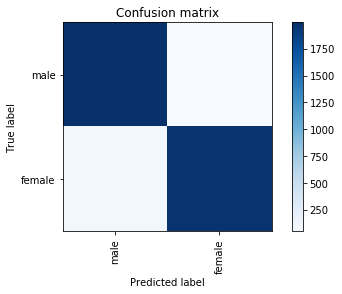

             precision    recall  f1-score   support

          0       0.95      0.98      0.97      2043
          1       0.98      0.95      0.96      2066

avg / total       0.97      0.96      0.96      4109



In [37]:
cnn_pred = model.predict(x_test)
cnn_pred = np.argmax(cnn_pred,axis=1)
y_true = np.argmax(y_test,axis=1)

cnn_f1 = metrics.f1_score(y_true, cnn_pred, average= "weighted")
cnn_accuracy = metrics.accuracy_score(y_true, cnn_pred)
cnn_cm = metrics.confusion_matrix(y_true, cnn_pred)
printmd("-----------------**Convolutional Neural Network Report**---------------")
print("F1 score: {}".format(cnn_f1))
print("Accuracy score: {}".format(cnn_accuracy))
print("Confusion matrix: \n", cnn_cm)
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cnn_cm, ["male", "female"])
plt.show()

print(metrics.classification_report(y_true, cnn_pred))

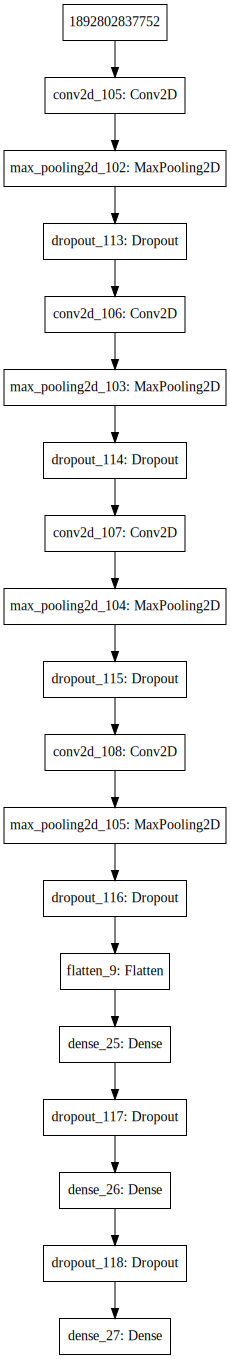

# Neural Network Embedding

In [ ]:
start = time.time()
checkpointer = ModelCheckpoint(filepath="save/deepcnn.hdf5", verbose=0, save_best_only=True) # save best model
#input_shape = (250, 250, 3)
input_shape = (100, 100, 3)
learning_rate = 0.001

#Build network
model = Sequential()

model.add(Conv2D(96, kernel_size=(3, 3), strides=(1, 1), padding='valid',
                 activation='relu',
                 input_shape=input_shape)) 
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
model.add(Dropout(0.25)) 

model.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='valid',activation='relu')) 
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
model.add(Dropout(0.25)) 

model.add(Conv2D(256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
model.add(Dropout(0.25)) 

model.add(Conv2D(512, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
model.add(Dropout(0.25)) 

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.35))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.35))
model.add(Dense(y_train.shape[1], activation='softmax'))

model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=learning_rate), metrics=['accuracy'])

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

model.fit(x_train,y_train, validation_split=0.2, callbacks=[monitor,checkpointer],verbose=1,epochs=50, batch_size=64, shuffle=True)    # Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.
    
print('Training finished...Loading the best model')  
end = time.time()
cnn_time = end-start
print("Total training time is {:0.2f} minute".format(cnn_time/60.0))